# 7 Working with Keras: A deep dive
The design of the Keras API is guided by the principle of progressive disclosure of complexity: make it easy to get started, yet make it possible to handle high-complexity use cases.

Three ways of using Keras:

1. The Sequential model, the most approachable API—it’s basically a Python list. As such, it’s limited to simple stacks of layers.
2. The Functional API, which focuses on graph-like model architectures. It represents a nice mid-point between usability and flexibility, and as such, it’s the most commonly used model-building API.
3. Model subclassing, a low-level option where you write everything yourself from scratch. This is ideal if you want full control over every little thing. However, you won’t get access to many built-in Keras features, and you will be more at risk of making mistakes.


## The Sequential Model

In [16]:

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [17]:
#or 
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [18]:
# the Sequential model does not have any weights until you actually call it on some data, or call its build() method with an input shape
model.build(input_shape=(None, 3))

In [19]:
# you can’t print a summary until the model is built
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

## The Functional API
This is what most Keras models you’ll encounter in the wild use. It’s fun and powerful—it feels like playing with LEGO bricks

In [20]:
# This inputs object holds information about the shape and dtype of the data that the model will process.
# We call such an object a symbolic tensor, it stands for future tensors of data.
inputs = keras.Input(shape=(3,), name="my_input")
# All Keras layers can be called both on real tensors of data and on these symbolic tensors.
# In the latter case, they return a new symbolic tensor, with updated shape and dtype information.
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
# After obtaining the final outputs, we instantiated the model by specifying its inputs and outputs in the Model constructor.
model = keras.Model(inputs=inputs, outputs=outputs)

### Multi-input, multi-output models
Example:
Let’s say you’re building a system to rank customer support tickets by priority and route them to the appropriate department. Your model has three inputs:

- The title of the ticket (text input)
- The text body of the ticket (text input)
- Any tags added by the user (categorical input, assumed here to be one-hot encoded)

We can encode the text inputs as arrays of ones and zeros of size vocabulary_size (see chapter 11 for detailed information about text encoding techniques).

Your model also has two outputs:
- The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)
- The department that should handle the ticket (a softmax over the set of departments)


In [21]:
# Defining the Model

vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

In [22]:
# Training the Model
import numpy as np

num_samples = 1280
titles = np.random.randint(low=0, high=2, size=(num_samples, vocabulary_size))
text_body = np.random.randint(low=0, high=2, size=(num_samples, vocabulary_size))
tags = np.random.randint(low=0, high=2, size=(num_samples, num_tags))

priority = np.random.random(size=(num_samples, 1))
department = np.random.randint(low=0, high=2, size=(num_samples, num_departments))

# We have two outputs, thus we pass two loss functions and two metrics
model.compile(optimizer="adam", loss=["categorical_crossentropy", "mean_squared_error"],
              metrics=["accuracy", "mean_absolute_error"])
model.fit([titles, text_body, tags], [priority, department], epochs=1)
model.evaluate([titles, text_body, tags], [priority, department], return_dict=True)


/Users/osamaabuhamdan/PycharmProjects/DNNResearchProject/venv/lib/python3.11/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
2024-02-25 21:27:35.764946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - department_mean_absolute_error: 0.4971 - loss: 0.4807 - priority_accuracy: 0.0000e+00
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - department_mean_absolute_error: 0.5075 - loss: 0.5075 - priority_accuracy: 0.0000e+00


{'department_mean_absolute_error': 0.5044921636581421,
 'loss': 0.5044921636581421,
 'priority_accuracy': 0.0}

### The power of the Functional API: Access to layer connectivity
- A Functional model is an explicit graph data structure.
- This makes it possible to inspect how layers are connected and reuse previous graph nodes (which are layer outputs) as part of new models.
- The model.layers model property provides the list of layers that make up the model, and for each layer you can query layer.input and layer.output.
- This enables you to do feature extraction, creating models that reuse intermediate features from another model.

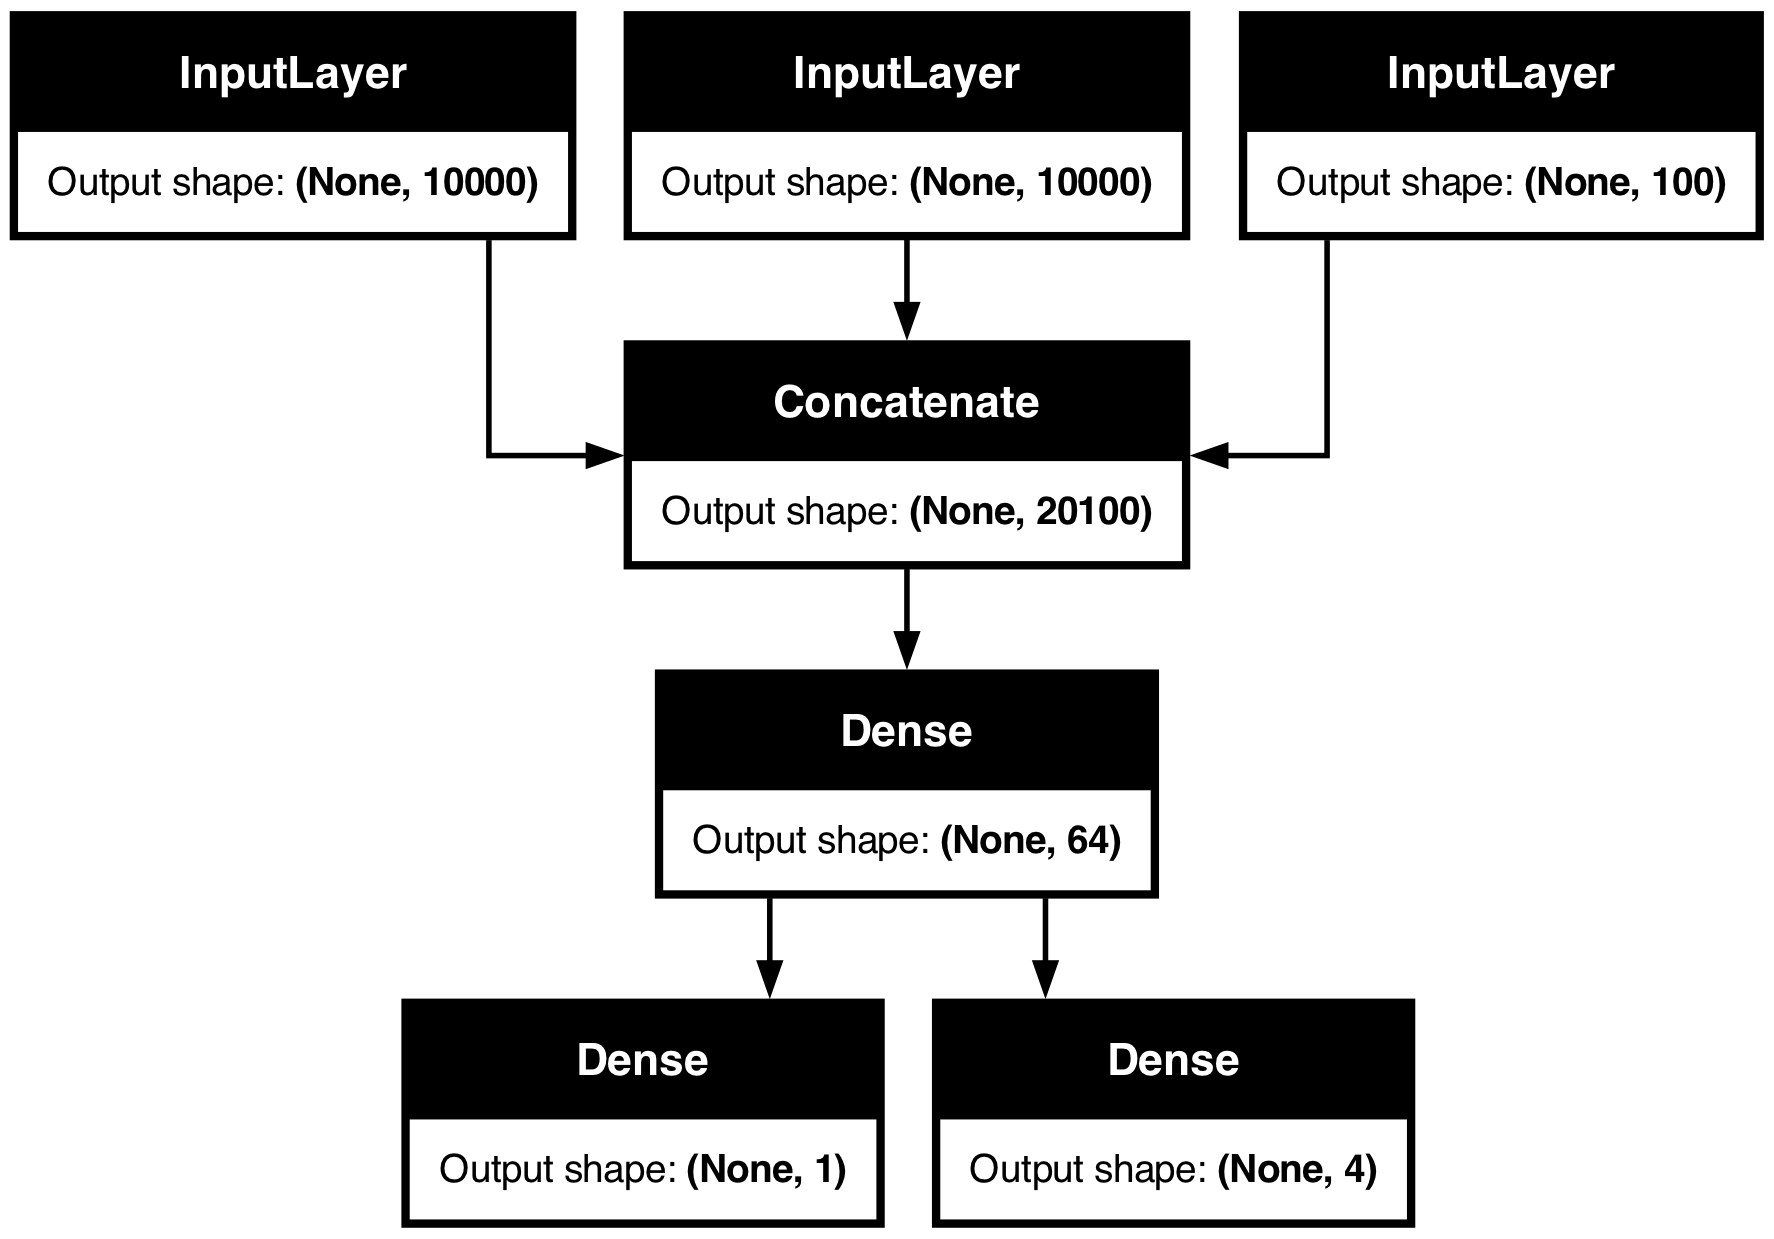

In [23]:
keras.utils.plot_model(model, show_shapes=True)
# The “None” in the tensor shapes represents the batch size: this model allows batches of any size.

In [24]:
# The model.layers model property provides the list of layers that make up the model, and for each layer you can query layer.input and layer.output.
print(model.layers[3].input)
print(model.layers[3].output)

[<KerasTensor shape=(None, 10000), dtype=float32, sparse=None, name=title>, <KerasTensor shape=(None, 10000), dtype=float32, sparse=None, name=text_body>, <KerasTensor shape=(None, 100), dtype=float32, sparse=None, name=tags>]
<KerasTensor shape=(None, 20100), dtype=float32, sparse=False, name=keras_tensor_16>


## Subclassing the Model class
- In the \_\_init\_\_() method, define the layers the model will use.
- In the call() method, define the forward pass of the model, reusing the layers previously created.
- Instantiate your subclass, and call it on data to create its weights
- The structure of what you pass as the loss and metrics arguments must match exactly what gets returned by call().
- The structure of the input data must match exactly what is expected by the call() method.
- The structure of the target data must match exactly what is returned by the call() method.

In [25]:
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs[0]
        text_body = inputs[1]
        tags = inputs[2]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        # return the outputs
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [26]:
model = CustomerTicketModel(num_departments=4)

model.compile(optimizer="adam", loss=["categorical_crossentropy", "mean_squared_error"],
              metrics=["accuracy", "mean_absolute_error"])
model.fit([titles, text_body, tags], [priority, department], epochs=1)
model.evaluate([titles, text_body, tags], [priority, department], return_dict=True)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0000e+00 - loss: 0.4657 - mean_absolute_error: 0.4919
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.4951 - mean_absolute_error: 0.4951


{'accuracy': 0.0,
 'loss': 0.4966796934604645,
 'mean_absolute_error': 0.4966796934604645}

### Beware: What subclassed models don’t support
- Calling summary() will not display layer connectivity
- You cannot plot the model topology via plot_model().
- You cannot access the nodes of the graph of layers to do feature extraction.

### Mixing and matching different components
All models in the Keras API can smoothly interoperate with each other, whether they’re Sequential models, Functional models, or subclassed models written from scratch. They’re all part of the same spectrum of workflows.

In [27]:
class Classifier(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)


inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

## Using built-in training and evaluation loops 

**The standard workflow of a DNN**
- compile(): Choose the Loss, Accuracy, and the Metrics
- fit(): Train model on data, validate on validation set
- evaluate(): Evaluate model on test set
- predict(): Predict new instances

A Keras metric is a subclass of the "keras.metrics.Metric" class.
Like layers, a metric has an internal state stored in TensorFlow variables.
Thus, you have to define:
1. init
2. update_state: update the current loss (based on the loss algorithm)
3. result: to return the current value of the metric
4. reset_state: enables the same metric objects to be used across different epochs of training

### Using callbacks
A callback is an object (a class instance implementing specific methods) that is passed to the model in the call to fit() and that is called by the model at various points during training.

It has access to all the available data about the state of the model and its performance, and it can take actions:
- interrupt training
- save a model
- load a different weight set
- alter the state of the model

Examples of using callbacks:
- **Model checkpointing** Saving the current state of the model at different points during training.
- **Early stopping—Interrupting training** when the validation loss is no longer improving (and of course, saving the best model obtained during training).
- **Dynamically adjusting the value of certain parameters during training** Such as the learning rate of the optimizer.
- **Logging training and validation metrics during training**, or visualizing the representations learned by the model as they’re updated

### EarlyStopping Callback
**With EarlyStopping callback you can stop training when you measure that the validation loss is no longer improving**

This callback allows you to interrupt training as soon as you start overfitting, thus avoiding having to retrain your model for a smaller number of epochs.

This callback is typically used in combination with **ModelCheckpoint**
<br/>
### ModelCheckpoint Callback

This callback lets you continually save the model during training.

Also, you can save only the current best model so far: the version of the model that achieved the best performance at the end of an epoch

In [28]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist


def get_mnist_model():
    inputs = keras.layers.Input(shape=(28 * 28,))
    features = keras.layers.Dense(64, activation="relu")(inputs)
    features = keras.layers.Dense(64, activation="relu")(features)
    features = keras.layers.Dropout(0.5)(features)
    outputs = keras.layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



In [29]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",  # Monitors the model’s validation accuracy
        patience=2,  # Interrupts training when accuracy has stopped improving for two epochs
    ),
    keras.callbacks.ModelCheckpoint(  # Saves the current weights after every epoch
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]
model = get_mnist_model()
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))
# Note that it stopped before 10 epochs since it stopped improving and started overfitting

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7712 - loss: 0.7366 - val_accuracy: 0.9456 - val_loss: 0.1911
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9341 - loss: 0.2336 - val_accuracy: 0.9594 - val_loss: 0.1476
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9520 - loss: 0.1773 - val_accuracy: 0.9637 - val_loss: 0.1325
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9588 - loss: 0.1616 - val_accuracy: 0.9644 - val_loss: 0.1490
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9621 - loss: 0.1498 - val_accuracy: 0.9657 - val_loss: 0.1433
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9613 - loss: 0.1489 - val_accuracy: 0.9679 - val_loss: 0.1431
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9645 - loss: 0.1443 - val_accuracy: 0.9690 - val_loss: 0.1582
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9660 - loss: 0

Note:
You can always save models manually after training as well, just call
```model.save('my_checkpoint_path').```
To reload the model you’ve saved, just use
```keras.models.load_model("checkpoint_path.keras")```

### Writing Custom Callbacks
Callbacks are implemented by subclassing the keras.callbacks.Callback class.
These are the methods to override:
- on_epoch_begin(epoch, logs) 
- on_epoch_end(epoch, logs)
- on_batch_begin(batch, logs)
- on_batch_end(batch, logs)
- on_train_begin(logs)
- on_train_end(logs)

These methods are all called with a logs argument, which is a dictionary containing information about the previous batch, epoch, or training run—training and validation metrics, and so on. The on_epoch_* and on_batch_* methods also take the epoch or batch index as their first argument (an integer).

### Monitoring and visualization with TensorBoard
To do good research or develop good models, you need rich, frequent feedback about what’s going on inside your models during your experiments.
With TensorBoard, you can

- Visually monitor metrics during training
- Visualize your model architecture
- Visualize histograms of activations and gradients
- Explore embeddings in 3D

**The easiest way to use TensorBoard with a Keras model and the fit() method is to use the keras.callbacks.TensorBoard callback**

In [30]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="./",
)
model.fit(train_images, train_labels,
          epochs=2,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

%load_ext tensorboard
%tensorboard --logdir ./

Epoch 1/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7606 - loss: 0.7587 - val_accuracy: 0.9400 - val_loss: 0.2047
Epoch 2/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9297 - loss: 0.2512 - val_accuracy: 0.9526 - val_loss: 0.1658


Launching TensorBoard...

## Writing your own training and evaluation loops

- Not every form of machine learning falls in the category of supervised learning, which fit() takes care of. 
- There are other setups where no explicit targets are present, such as
    - Generative learning
    - Self-supervised learning (where targets are obtained from the inputs)
    - Reinforcement learning (where learning is driven by occasional “rewards,” much like training a dog)

 **As a reminder, the contents of a typical training loop look like this:**
- Run the forward pass (compute the model’s output) inside a gradient tape to obtain a loss value for the current batch of data.
- Retrieve the gradients of the loss with regard to the model’s weights.
- Update the model’s weights so as to lower the loss value on the current batch of data.


**In this section, you will learn to reimplement fit() from scratch**



### Training versus inference
Low Level Training Loop consists of:
1. Forward Pass
2. Loss
3. Get Gradients
4. Update Gradients

#### Forward Pass
- Some Keras layers, such as the Dropout layer, have different behaviors during training and during inference (when you use them to generate predictions).
    - Calling dropout(inputs, training=True) will drop some activation entries, while calling dropout(inputs, training=False) does nothing.
-  Remember to pass training =True when you call a Keras model during the forward pass!
    - predictions = model(inputs, training=True)

#### Gradients
Layers and models own two kinds of weights:
- **Trainable weights**: These are meant to be updated via backpropagation to minimize the loss of the model.
- **Non-trainable weights**: These are meant to be updated during the forward pass by the layers that own them. For instance, if you wanted a custom layer to keep a counter of how many batches it has processed so far.

Thus, use 
```tape.gradients(loss, model.trainable_weights)```
instead of 
```tape.gradients(loss, model.weights)``` 

Among Keras built-in layers, the only layer that features non-trainable weights is the BatchNormalization layer, which we will discuss in chapter 9. The BatchNormalization layer needs non-trainable weights in order to track information about the mean and standard deviation of the data that passes through it, so as to perform an online approximation of feature normalization.


## This is one training step from scratch

In [34]:
model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy(), keras.metrics.Mean()]


def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)  # forward pass
        loss = loss_fn(targets, predictions)  # forward pass
    gradients = tape.gradient(loss, model.trainable_weights)  # backward pass
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))  # backward pass

    # keep track of metrics
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    return logs

What if you need a custom training algorithm, but you still want to leverage the power of the built-in Keras training logic?
- We create a new class that subclasses keras.Model.
- We override the method train_step(self, data). It returns a dictionary mapping metric names (including the loss) to their current values.
- We implement a metrics property that tracks the model’s Metric instances. This enables the model to automatically call reset_state() on the model’s metrics at the start of each epoch and at the start of a call to evaluate().


In [32]:
import tensorflow as tf

loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")  # Here it works a s a metric


class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)  # forward 
            loss = loss_fn(targets, predictions)  # forward - loss of one batch only
        gradients = tape.gradient(loss, self.trainable_weights)  # backward
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))  # update trainable weights

        loss_tracker.update_state(loss)  # update the cumulative loss over batches
        return {"loss": loss_tracker.result()}  # retrieve the current value of the average loss.

    @property
    def metrics(self):
        return [loss_tracker]

In [33]:
# Now you can use the builtin functions like compile and fit
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())  # loss is not used here since it's used explicitly above
model.fit(train_images, train_labels, epochs=3)

## NOTES: ##
# This pattern does not prevent you from building models with the Functional API. You can do this whether you’re building Sequential models, Functional API models, or subclassed models.

# You don’t need to use a @tf.function decorator when you override train_ step—the framework does it for you.


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.4425
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1710
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1296


In [33]:
# Or you can pass your metric with compile and use the self.compiled_metrics.update_state
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}   

In [ ]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)
  
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)